In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
import torch
from PIL import Image
import numpy as np

import os
from datetime import datetime
import matplotlib.pyplot as plt

import math
import shutil
from google.colab import drive
from PIL import Image

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Konstantos**


1.   ```LOAD_CHECKPOINT``` - switch to True to load existing checkpoint from path
2.   ```USE_SUBSET``` - switch to True to use a part of dataset (useful for testing purposes)
3. ```TRAIN_SUBSET_SIZE``` - define size of train part of dataset
4. ```VALID_SUBSET_SIZE``` - define a size of test part of dataset

**WARNING!!! IMPORTANT!!!**


1.   Jei norite bandyti trainint (patestuot) ir nežinote ar gerai bus, geriausia pakeiskite ```CHECKPOINT_FILENAME``` į kokį nors kitą, kad neprarastume rezultatus. ```checkpoint_poultry``` checkpointa naudokime kaip final versiją.



In [18]:
FEATURE_EXTRACTION = True
CLASS_LIST = ["healthy", "salmo", "cocci", "ncd"]
CLASS_INDICES = {'healthy': 0, 'salmo': 1, 'cocci': 2, 'ncd': 3}
EPOCH_COUNT = 5
TO_RECOGNIZE = 5

TRAIN_PART = 0.8
LEARNING_RATE = 1e-3

LOAD_CHECKPOINT = False
ROOT_DIR = "/content/drive/MyDrive/project"
CHECKPOINT_FILENAME = "/content/drive/MyDrive/project/checkpoint_poultry.tar"

USE_SUBSET = True
TRAIN_SUBSET_SIZE = 50 * len(CLASS_LIST)
VALID_SUBSET_SIZE = 15 * len(CLASS_LIST)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:0


**Some helper functions**

In [4]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [5]:
def load_checkpoint(filename, model, optimizer):
    print("Loading checkpoint...")
    checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    training_history = {
        "epoch": checkpoint.get("epoch", 0),
        "train_loss_history": checkpoint.get("train_loss_history", []),
        "accuracy_history": checkpoint.get("accuracy_history", []),
        "train_accuracy_history": checkpoint.get("train_accuracy_history", []),
        "val_loss_history": checkpoint.get("val_loss_history", []),
        "precision_history": checkpoint.get("precision_history", []),
        "recall_history": checkpoint.get("recall_history", []),
        "f1_score_history": checkpoint.get("f1_score_history", []),
        "stats_history": checkpoint.get("stats_history", []),
        "conf_matrix": checkpoint.get("conf_matrix", [])
    }

    return training_history

**Vištų šūdukų datasetas paruoštas klasifikavimo uždaviniui**

In [6]:
class PoultryDatasetClassification(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

def create_datasets(root_dir, data_classes, test_size=0.2, random_state=42):
    image_paths = []
    labels = []
    class_indices = {data_class: i for i, data_class in enumerate(data_classes)}

    for data_class in data_classes:
        images_dir = os.path.join(root_dir, data_class, data_class)
        if not os.path.exists(images_dir):
            print(f"Directory does not exist: {images_dir}")
            continue

        for img in os.listdir(images_dir):
            if img.endswith(".jpg"):
                image_paths.append(os.path.join(images_dir, img))
                label = [0] * len(data_classes)
                label[class_indices[data_class]] = 1  # One-hot encoding
                labels.append(label)

    # Split data while keeping the distribution of classes consistent
    img_train, img_test, labels_train, labels_test = train_test_split(
        image_paths, labels, test_size=test_size, random_state=random_state, stratify=labels
    )

    # Applying transformations
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Creating dataset objects for training and testing
    train_dataset = PoultryDatasetClassification(img_train, labels_train, transform=transform_train)
    test_dataset = PoultryDatasetClassification(img_test, labels_test, transform=transform_test)

    return train_dataset, test_dataset


In [7]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_train_loss = np.array([], dtype=np.float32)
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels_as_indices = torch.argmax(labels, dim=1)

        outputs = model(images)

        loss = criterion(outputs, labels_as_indices)
        running_train_loss = np.append(running_train_loss, loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, axis = 1)
        correct_predictions += (predicted == labels_as_indices).sum().item()
        total_predictions += labels_as_indices.size(0)

    train_loss = np.mean(running_train_loss)
    train_accuracy = correct_predictions / total_predictions

    return train_loss, train_accuracy

**Skaičiuojamos metrikos visiems predictionams**

In [8]:
def calculate_metrics(correct_predictions, total_predictions, y_true, y_pred):
    print('Total predictions: ', total_predictions)
    print('Correct predictions: ', correct_predictions)

    accuracy = correct_predictions / total_predictions
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, conf_matrix

**Skaičiuojamos metrikos kiekvienai klasei su pasirinktu threshold**

In [9]:
def calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.8):
    num_classes = all_true_labels.shape[1]
    stats = {}
    for class_index in range(num_classes):
        predictions = (all_confidences[:, class_index] >= threshold).astype(int)

        true_labels = all_true_labels[:, class_index].astype(int)

        TP = np.sum((predictions == 1) & (true_labels == 1))
        TN = np.sum((predictions == 0) & (true_labels == 0))
        FP = np.sum((predictions == 1) & (true_labels == 0))
        FN = np.sum((predictions == 0) & (true_labels == 1))

        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        stats[class_index] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

    return stats

**Evaluation loop'as**

In [10]:
def evaluate_epoch(model, test_loader, criterion, optimizer):
    model.eval()
    running_val_loss = np.array([], dtype = np.float32)
    correct_predictions, total_predictions = 0, 0
    y_true, y_pred, all_confidences, all_true_labels = [], [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels_as_indices = torch.argmax(labels, axis=1).to(device)

            outputs = model(images)

            confidences = torch.sigmoid(outputs)

            val_loss = criterion(outputs, labels_as_indices)
            running_val_loss = np.append(running_val_loss, val_loss.cpu().detach().numpy())

            predicted = torch.argmax(outputs, axis = 1)

            correct_predictions += (predicted == labels_as_indices).sum().item()
            total_predictions += labels_as_indices.size(0)

            y_true.extend(labels_as_indices.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            all_confidences.extend(confidences.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    all_confidences = np.array(all_confidences)
    all_true_labels = np.array(all_true_labels)

    stats = calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.5)

    for class_index, class_stats in stats.items():
        print(f"Class {class_index}:")
        print(f" Accuracy: {class_stats['accuracy']}")
        print(f" Precision: {class_stats['precision']}")
        print(f" Recall: {class_stats['recall']}")
        print(f" F1 Score: {class_stats['f1_score']}")

    return np.mean(running_val_loss), correct_predictions, total_predictions, y_true, y_pred, stats

**Pagrindnis loop'as, išsaugom istoriją kad ateityje būtų galima nubraižyt fancy grafikelius**

In [25]:
def train_and_eval(model, loader_train, loader_valid, filename, epoch_count, lr):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam([
      {'params': model.resnet50.parameters(), 'lr': lr * 0.1},
      {'params': model.dense1.parameters(), 'lr': lr},
      {'params': model.dropout.parameters(), 'lr': lr},
      {'params': model.dense2.parameters(), 'lr': lr}
  ])

  start_time = datetime.now()

  training_history = None

  if LOAD_CHECKPOINT:
      training_history = load_checkpoint(filename, model, optimizer)
      start_epoch = training_history['epoch'] + 1
      train_loss_history = training_history['train_loss_history']
      accuracy_history = training_history['accuracy_history']
      train_accuracy_history = training_history['train_accuracy_history']
      val_loss_history = training_history['val_loss_history']
      precision_history = training_history['precision_history']
      recall_history = training_history['recall_history']
      f1_score_history = training_history['f1_score_history']
      stats_history = training_history['stats_history']
      conf_matrix = training_history['conf_matrix']
  else:
      start_epoch = 0
      train_loss_history = []
      val_loss_history = []
      accuracy_history = []
      train_accuracy_history = []
      precision_history = []
      recall_history = []
      f1_score_history = []
      stats_history = []
      conf_matrix = []

  for epoch in range(start_epoch, epoch_count):
      print('Starting training epoch... ', epoch)
      start_time = datetime.now()

      train_loss, train_accuracy = train_epoch(model, loader_train, loss_func, optimizer)

      current_time = datetime.now()
      elapsed = seconds_to_time((current_time - start_time).total_seconds())
      print(f'Epoch: {epoch}, Time: {elapsed}, Loss: {train_loss}')

      print('Starting evaluation... ', start_time)
      start_time = datetime.now()

      avg_val_loss, correct_predictions, total_predictions, y_true, y_pred, stats = evaluate_epoch(model, test_loader, loss_func, optimizer)

      accuracy, precision, recall, f1, conf_matrix = calculate_metrics(correct_predictions, total_predictions, y_true, y_pred)

      current_time = datetime.now()
      per_image = (current_time - start_time).total_seconds() / total_predictions
      print(f'Time: {per_image * 1000}ms, Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}')
      print(f'Confusion matrix: {conf_matrix}')

      accuracy_history.append(accuracy)
      train_accuracy_history.append(train_accuracy)
      train_loss_history.append(train_loss)
      val_loss_history.append(avg_val_loss)
      precision_history.append(precision)
      recall_history.append(recall)
      f1_score_history.append(f1)
      stats_history.append(stats)

      print("Saving checkpoint...")
      checkpoint = {
          "epoch": epoch,
          "state_dict": model.state_dict(),
          "optimizer": optimizer.state_dict(),
          "train_loss_history": train_loss_history,
          "accuracy_history": accuracy_history,
          "train_accuracy_history": train_accuracy_history,
          "val_loss_history": val_loss_history,
          "precision_history": precision_history,
          "recall_history": recall_history,
          "f1_score_history": f1_score_history,
          "stats_history": stats_history,
          "conf_matrix": conf_matrix
      }
      torch.save(checkpoint, filename)
  return training_history


In [15]:
train_dataset, test_dataset = create_datasets(ROOT_DIR, CLASS_LIST)

if USE_SUBSET:
  train_dataset = Subset(train_dataset, range(TRAIN_SUBSET_SIZE))
  test_dataset = Subset(test_dataset, range(VALID_SUBSET_SIZE))

print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')

num_workers = 2
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

Train: 200, Test: 60


**ResNet50 model modification**

In [20]:
class PoultryDiseaseClassifier(nn.Module):
    def __init__(self):
        super(PoultryDiseaseClassifier, self).__init__()
        self.resnet50 = resnet50
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(num_ftrs, 256)
        self.dropout = nn.Dropout(0.3)
        self.dense2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.resnet50(x)
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

**Užfreezinti visi parametrai išskyrus paskutinį sluoksnį**

In [26]:
filename = CHECKPOINT_FILENAME

resnet50 = models.resnet50(pretrained=True)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Identity()

model = PoultryDiseaseClassifier()
model.to(device)

print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
training_history = train_and_eval(model, train_loader, test_loader, filename, epoch_count = EPOCH_COUNT, lr = LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter count: 24,033,604
Starting training epoch...  0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0, Time: 12s, Loss: 1.233386754989624
Starting evaluation...  2024-05-17 11:18:14.152932
Class 0:
 Accuracy: 0.8
 Precision: 0.6333333333333333
 Recall: 0.95
 F1 Score: 0.7599999999999999
Class 1:
 Accuracy: 0.5666666666666667
 Precision: 0.43478260869565216
 Recall: 1.0
 F1 Score: 0.6060606060606061
Class 2:
 Accuracy: 0.5666666666666667
 Precision: 0.38095238095238093
 Recall: 1.0
 F1 Score: 0.5517241379310345
Class 3:
 Accuracy: 0.9333333333333333
 Precision: 0
 Recall: 0.0
 F1 Score: 0
Total predictions:  60
Correct predictions:  46
Time: 60.473683333333334ms, Epoch 0, Train Loss: 1.2334, Val Loss: 0.6088, Accuracy: 0.7667, Precision: 0.7512, Recall: 0.7667, F1 score: 0.7414
Confusion matrix: [[17  1  2  0]
 [ 2 13  5  0]
 [ 0  0 16  0]
 [ 0  1  3  0]]
Saving checkpoint...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting training epoch...  1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Time: 13s, Loss: 0.7037754058837891
Starting evaluation...  2024-05-17 11:18:31.419248
Class 0:
 Accuracy: 0.9333333333333333
 Precision: 0.8333333333333334
 Recall: 1.0
 F1 Score: 0.9090909090909091
Class 1:
 Accuracy: 0.6166666666666667
 Precision: 0.46511627906976744
 Recall: 1.0
 F1 Score: 0.6349206349206349
Class 2:
 Accuracy: 0.7833333333333333
 Precision: 0.5517241379310345
 Recall: 1.0
 F1 Score: 0.7111111111111111
Class 3:
 Accuracy: 0.9333333333333333
 Precision: 0
 Recall: 0.0
 F1 Score: 0
Total predictions:  60
Correct predictions:  53
Time: 55.39886666666667ms, Epoch 1, Train Loss: 0.7038, Val Loss: 0.2460, Accuracy: 0.8833, Precision: 0.8343, Recall: 0.8833, F1 score: 0.8546
Confusion matrix: [[18  2  0  0]
 [ 0 19  1  0]
 [ 0  0 16  0]
 [ 0  3  1  0]]
Saving checkpoint...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting training epoch...  2


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2, Time: 14s, Loss: 0.28554970026016235
Starting evaluation...  2024-05-17 11:18:49.849632
Class 0:
 Accuracy: 0.95
 Precision: 1.0
 Recall: 0.85
 F1 Score: 0.9189189189189189
Class 1:
 Accuracy: 0.8666666666666667
 Precision: 0.7307692307692307
 Recall: 0.95
 F1 Score: 0.8260869565217392
Class 2:
 Accuracy: 0.5666666666666667
 Precision: 0.38095238095238093
 Recall: 1.0
 F1 Score: 0.5517241379310345
Class 3:
 Accuracy: 0.95
 Precision: 0.6
 Recall: 0.75
 F1 Score: 0.6666666666666665
Total predictions:  60
Correct predictions:  52
Time: 66.12228333333334ms, Epoch 2, Train Loss: 0.2855, Val Loss: 0.3866, Accuracy: 0.8667, Precision: 0.8244, Recall: 0.8667, F1 score: 0.8385
Confusion matrix: [[17  1  2  0]
 [ 0 19  1  0]
 [ 0  0 16  0]
 [ 0  2  2  0]]
Saving checkpoint...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting training epoch...  3


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3, Time: 14s, Loss: 0.19707337021827698
Starting evaluation...  2024-05-17 11:19:09.104742
Class 0:
 Accuracy: 0.9666666666666667
 Precision: 0.9090909090909091
 Recall: 1.0
 F1 Score: 0.9523809523809523
Class 1:
 Accuracy: 0.8833333333333333
 Precision: 0.76
 Recall: 0.95
 F1 Score: 0.8444444444444444
Class 2:
 Accuracy: 0.8
 Precision: 0.5714285714285714
 Recall: 1.0
 F1 Score: 0.7272727272727273
Class 3:
 Accuracy: 0.9666666666666667
 Precision: 0.75
 Recall: 0.75
 F1 Score: 0.75
Total predictions:  60
Correct predictions:  54
Time: 62.29803333333333ms, Epoch 3, Train Loss: 0.1971, Val Loss: 0.1958, Accuracy: 0.9000, Precision: 0.8416, Recall: 0.9000, F1 score: 0.8692
Confusion matrix: [[19  1  0  0]
 [ 0 19  1  0]
 [ 0  0 16  0]
 [ 1  2  1  0]]
Saving checkpoint...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting training epoch...  4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4, Time: 12s, Loss: 0.11161620169878006
Starting evaluation...  2024-05-17 11:19:28.453613
Class 0:
 Accuracy: 0.9333333333333333
 Precision: 0.8333333333333334
 Recall: 1.0
 F1 Score: 0.9090909090909091
Class 1:
 Accuracy: 0.8
 Precision: 0.625
 Recall: 1.0
 F1 Score: 0.7692307692307693
Class 2:
 Accuracy: 0.95
 Precision: 0.8421052631578947
 Recall: 1.0
 F1 Score: 0.9142857142857143
Class 3:
 Accuracy: 0.95
 Precision: 0.5714285714285714
 Recall: 1.0
 F1 Score: 0.7272727272727273
Total predictions:  60
Correct predictions:  56
Time: 88.72266666666667ms, Epoch 4, Train Loss: 0.1116, Val Loss: 0.1484, Accuracy: 0.9333, Precision: 0.9379, Recall: 0.9333, F1 score: 0.9294
Confusion matrix: [[19  1  0  0]
 [ 1 19  0  0]
 [ 0  0 16  0]
 [ 0  2  0  2]]
Saving checkpoint...


**Statistiku atvaizdavimas**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading checkpoint...


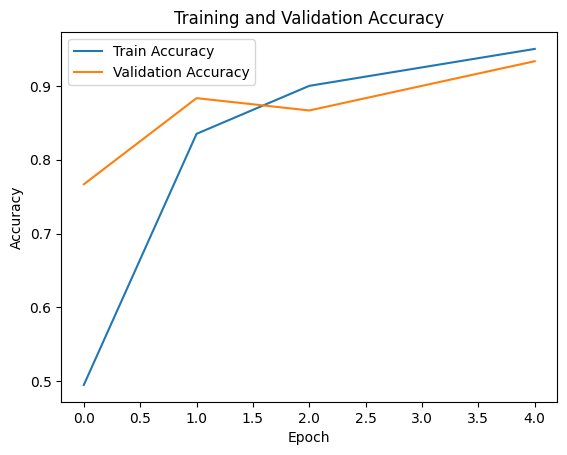

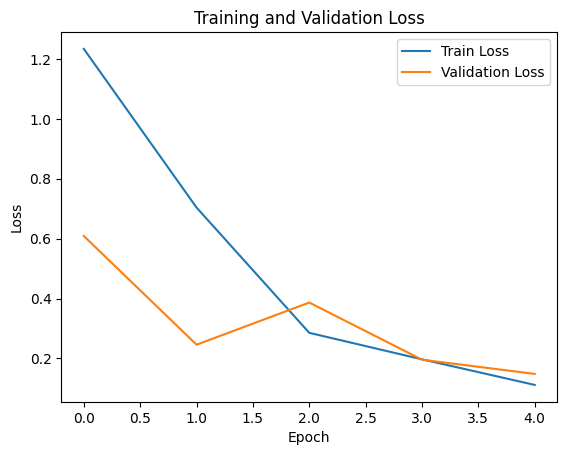

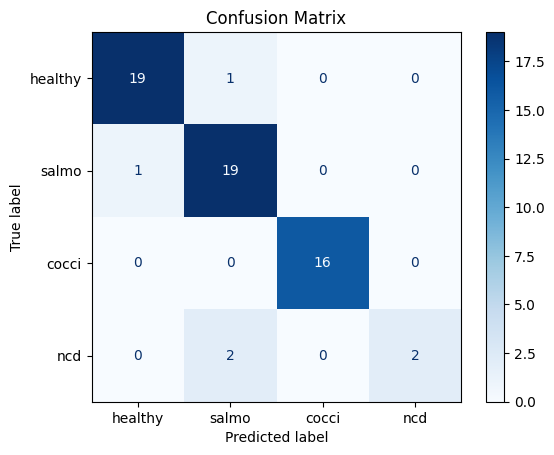

In [27]:
resnet50 = models.resnet50(pretrained=True)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Identity()

model = PoultryDiseaseClassifier()
model.to(device)

optimizer = optim.Adam([
    {'params': model.resnet50.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model.dense1.parameters(), 'lr': LEARNING_RATE},
    {'params': model.dropout.parameters(), 'lr': LEARNING_RATE},
    {'params': model.dense2.parameters(), 'lr': LEARNING_RATE}
])

training_history = load_checkpoint(CHECKPOINT_FILENAME, model, optimizer)

train_accuracy_history = training_history['train_accuracy_history']
accuracy_history = training_history['accuracy_history']
train_loss_history = training_history['train_loss_history']
val_loss_history = training_history['val_loss_history']
conf_matrix = training_history['conf_matrix']

plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

if isinstance(conf_matrix, list):
    last_conf_matrix = np.array(conf_matrix[-1])
else:
    last_conf_matrix = np.array(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=last_conf_matrix, display_labels=CLASS_LIST)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()